# Notebook for visualizing the outliers

In [25]:
import sys
sys.path.append('../tools')
from plot_tools import *
from map_tools import *
from params import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
mapper = joblib.load('../tools/mapper.sav')
curves = joblib.load('../tools/contours_kde.sav')
kde = joblib.load('../tools/kde_0_3.sav')

Set the method to visualize and get the time-stamps flagged by this method

In [17]:
# method = 'kde'
# method = 'gram_single'
# method = 'y_hat_chirp'
# method = 'y_hat_nota'
method = 'hardware_inj'

with h5py.File('../../shared/tois.hdf5', 'r') as f:
    tois = np.asarray(f[method])

If this is the first time visualizing load latent features, map space features, predictions and deviations for the time-stamps flagged and save them in the same file as the spectrograms

In [31]:
first_time = False
pois_file = 'pois/pois_new_gram_' + method + '.hdf5'

if first_time:
    for detector in ['H', 'L']:
        data_path = join(conditioned_path, detector + '1/' + condition_method)
        with h5py.File(join(data_path, pois_file), 'r') as f:
            times = np.asarray(f['times'])
        
        data_path = join(features_path, 'fromraw_' + condition_method + '/' + model + '/' + detector + '1')
        files = [f for f in sorted(listdir(data_path)) if isfile(join(data_path, f)) and f.split('.')[-1] == 'hdf5']
        features = []
        umap = []
        y_hat = []
        total_dev = []

        for t in times:
            file = find_file(t, files)
            if file is None:
                continue
            
            with h5py.File(join(data_path, file), 'r') as f:
                temp_times = (np.asarray(f['times']))

            idx = find_closest_index(t + 0.5, temp_times)
            with h5py.File(join(data_path, file), 'r') as f:
                features.append(np.asarray(f['features'][idx]))
                umap.append(np.asarray(f['umap'][idx]))
                y_hat.append(np.asarray(f['y_hat'][idx]))
                total_dev.append(np.asarray(f['total_dev'][idx]))


        features = np.asarray(features)
        umap = np.asarray(umap)
        y_hat = np.asarray(y_hat)
        total_dev = np.asarray(total_dev)
        
        data_path = join(conditioned_path, detector + '1/' + condition_method)
        with h5py.File(join(data_path, pois_file), 'a') as f:
            f.create_dataset('features', data=features)
            f.create_dataset('umap', data=umap)
            f.create_dataset('y_hat', data=y_hat)
            f.create_dataset('total_dev', data=total_dev)

print(features.shape)
print(umap.shape)

(1021, 100)
(1021, 2)


Load examples and create a dictionary used for plotting

In [27]:
x_examples, features_examples, y_examples, times_examples = load_train_examples(condition_method, model, features_path)
labels = np.unique(y_examples)

umap_examples = mapper.transform(features_examples)
tomap = {'ex': {'x': x_examples, 'y': y_examples, 'umap': umap_examples, 'times': times_examples}}

Load the flagged time-stamps

In [32]:
for detector in ['H', 'L']:
    data_path = join(conditioned_path, detector + '1/' + condition_method)
    with h5py.File(join(data_path, pois_file), 'r') as f:
        x = np.asarray(f['x'])
        times = np.asarray(f['times'])
        features = np.asarray(f['features'])
        umap = np.asarray(f['umap'])
        y_hat = np.asarray(f['y_hat'])
        total_dev = np.asarray(f['total_dev'])
    pred_idx = np.argmax(y_hat, axis=1)
    y = labels[pred_idx]
    tomap[detector] = {'x': x, 'y': y, 'umap': umap, 'times': times, 'features': features, 'total_dev': total_dev}

In [33]:
print(times[21])

1128671420.998


In [40]:
for key in tomap['H'].keys():
    print(key, tomap['H'][key].shape)

x (1021, 299, 299, 3)
y (1021,)
umap (1021, 2)
times (1021,)
features (1021, 100)
total_dev (1021,)


In [60]:
# print(tomap['H']['times'])
idx = tomap['H']['times'] > 1136700000
print(sum(idx))

986


In [61]:
tomap2 = {'ex': tomap['ex'], 'H': {}, 'L': {}}
for detector in ['H', 'L']:
    for key in tomap[detector].keys():
        tomap2[detector][key] = tomap[detector][key][idx]

In [62]:
umap = np.concatenate((tomap2['H']['umap'], tomap2['L']['umap']))
y_hat = np.concatenate((tomap2['H']['y'], tomap2['L']['y']))
times = np.concatenate((tomap2['H']['times'], tomap2['L']['times']))
print(umap.shape)
# print(np.asarray(len(list(umap_tot['H']))).shape)
title = 'loud long duration burst hardware injections'
layout = interactive_plot(umap, y_hat, times, title=title) * curves
layout

(1972, 2)


:Overlay
   .Points.I   :Points   [feature_1,feature_2]   (times,y,marker,size,index)
   .Contours.I :Contours   [x,y]   (z)

In [63]:
hv.save(layout, '/Users/tommarianer/Documents/Studying/Thesis/injection_maps/more_maps/' + title + '.html')

In [52]:
layout = plot_both_dets(tomap, plot_ex=False, title='time-stamps flagged by ' + method + ' method')
points = layout.Points
H_dmap = layout.DynamicMap.I
L_dmap = layout.DynamicMap.II
width = 400
height = 400
newlay = (points.opts(toolbar='below') * curves + hv.Empty() 
        + H_dmap.opts(frame_width=width, frame_height=height) 
        + L_dmap.opts(frame_width=width, frame_height=height)).opts(merge_tools=False).cols(2)
newlay

:Layout
   .Overlay.I     :Overlay
      .Points.I   :Points   [feature_1,feature_2]   (times,y,marker,size,index)
      .Contours.I :Contours   [x,y]   (z)
   .Empty.I       :Empty
   .DynamicMap.I  :DynamicMap   []
      :RGB   [x,y]   (R,G,B)
   .DynamicMap.II :DynamicMap   []
      :RGB   [x,y]   (R,G,B)

For each flagged time-stamp find which detector was flagged (there might be some that aren't flagged in either, these are time-stamps that were flagged in the modified chunks, if I would've dealt with these modified chunks better (i.e. deleted the repeating part) they wouldn't be there so for now I just ignore them... Not great, but for now will do...

In [15]:
if method == 'kde':
    th = kde_th
    kde_scores = {'H': [], 'L': []}
    for detector in ['H', 'L']:
        kde_scores[detector] = kde.score_samples(tomap[detector]['umap'])
    
    det_out = []
    for h_score, l_score in zip(kde_scores['H'], kde_scores['L']):
        if h_score < th and l_score < th:
            det_out.append('B')
        elif h_score < th:
            det_out.append('H')
        elif l_score < th:
            det_out.append('L')
        else:
            det_out.append('N')

if method == 'y_hat_chirp' or method == 'y_hat_nota':
    if method == 'y_hat_chirp':
        label = 'Chirp'
    else:
        label = 'None_of_the_Above'
    det_out = []
    for y_h, y_l in zip(tomap['H']['y'], tomap['L']['y']):
        if y_h == label and y_l == label:
            det_out.append('B')
        elif y_h == label:
            det_out.append('H')
        elif y_l == label:
            det_out.append('L')
        else:
            det_out.append('N')

if method == 'gram_single':
    th = gram_th
    det_out = []
    for h_score, l_score in zip(tomap['H']['total_dev'], tomap['L']['total_dev']):
        if h_score > th and l_score > th:
            det_out.append('B')
        elif h_score > th:
            det_out.append('H')
        elif l_score > th:
            det_out.append('L')
        else:
            det_out.append('N')

The next cells allows plotting for the flagged time-stamps the spectrograms from both detectors side-by-side, the red title denotes which spectrogram was flagged, 10 time-stamps at a time.
There are many things commented out, which allow different arrangements for plotting and saving, it's quite a mess, didn't feel like cleaning it up for now, hopefully sometime...

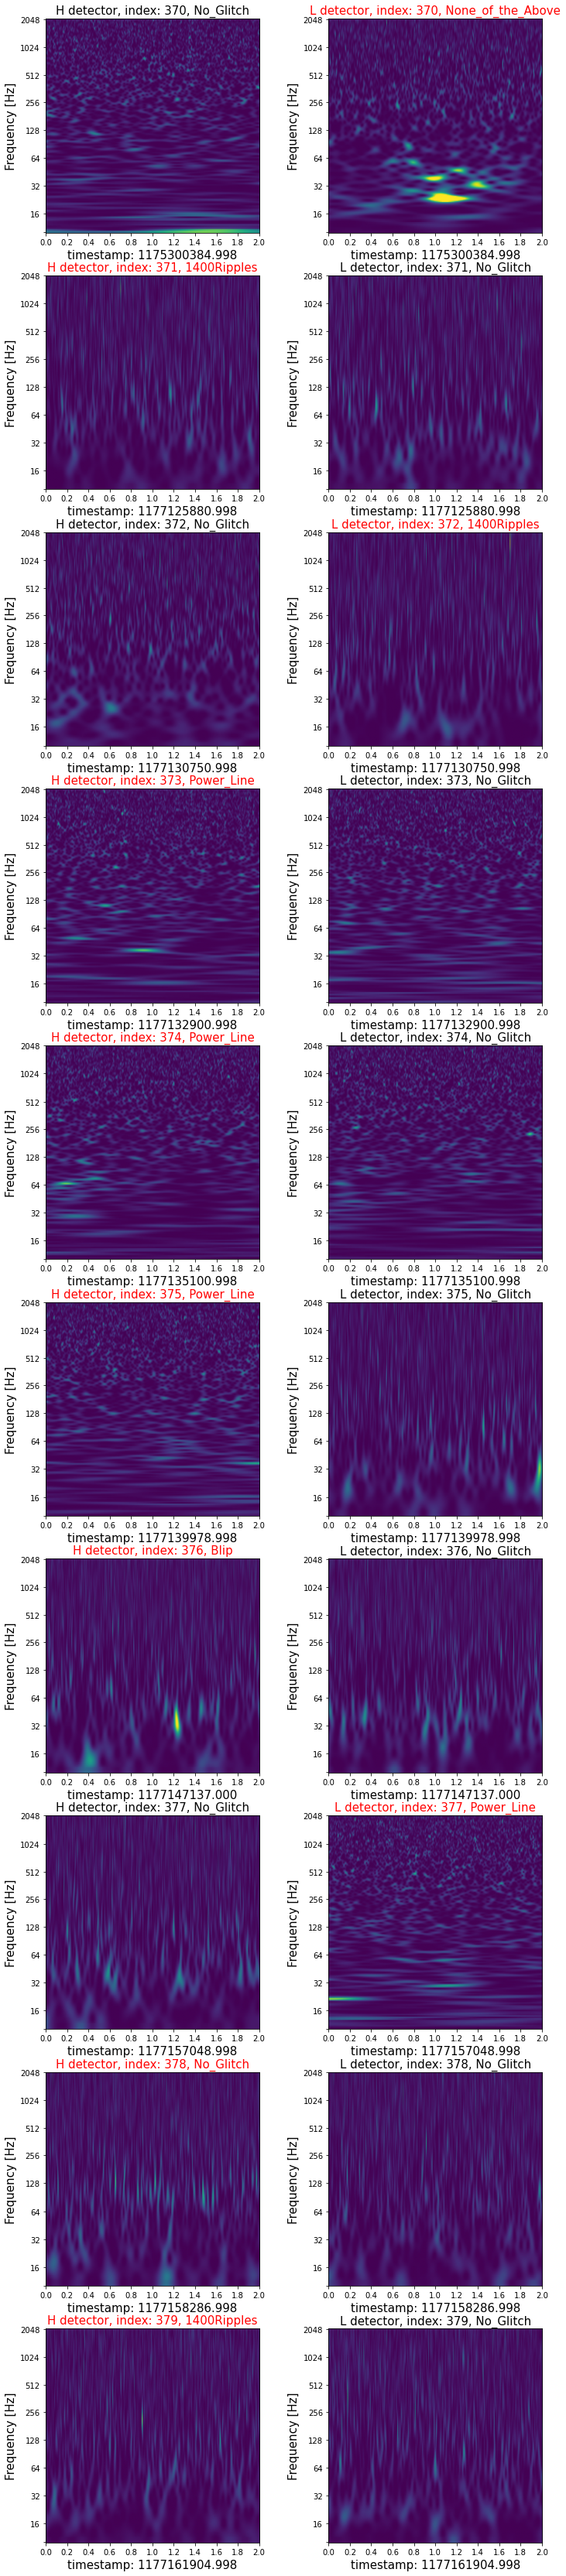

In [12]:
num_to_plot = 10 # len(tomap['H']['times'])
# if num_to_plot == 1:
#     figsize = (6*num_to_plot, 10)
#     size = 15
#     sub_cols = 2
#     sub_rows = num_to_plot
# else:
figsize = (12, 6*num_to_plot)
# figsize = (10, 6*num_to_plot)
# figsize = (6.5*num_to_plot, 6.5*2)
size = 15
#     figsize = (13, 6.5*num_to_plot)
#     size = 15
sub_cols = num_to_plot
sub_rows = 2
    
# fig = plt.figure(figsize=(12, 6*num_to_plot))
# fig = plt.figure(figsize=(6*num_to_plot, 12))
fig = plt.figure(figsize=figsize)
num = 370
# nums = [126] # kde both
# nums = [189] # gram_single both
# nums = [6, 9, 11, 12, 13, 14, 15, 17, 19, 20, 21, 22, 23, 24, 25] # y_hat_chirp both

# nums = [20, 21, 22, 23, 24, 25] # y_hat_chirp both
# nums = [1, 72, 73, 11, 55] # y_hat_chirp events and injection
# labels = ['GW150914', 'GW170809', 'GW170814', 'Hardware injection', 'Hardware injection']
# count = ['(a) ', '(b) ', '(c) ', '(d) ', '(e) ', '(f) ', '(g) ', '(h) ', 
#          '(i) ', '(j) ', '(k) ', '(l) ', '(m) ', '(n) ', '(o) ']
# nums = [11, 55] # y_hat_chirp injections

xtick_pos = np.linspace(0, tomap['H']['x'].shape[1] - 1, 11)
xtick_label = ["{:.1f}".format(label) for label in np.linspace(0, 2, 11)]

f_ax = np.flip(np.logspace(np.log10(10), np.log10(2048), tomap['H']['x'].shape[2]))
ytick_pos = []

# ytick_pos = np.linspace(0, tomap['H']['x'].shape[2] - 1, 9)
ytick_label = np.flip(np.logspace(4, 11, 8, base=2)).astype('int')
for tick in ytick_label:
    ytick_pos.append(min(range(len(f_ax)), key=lambda i: abs(f_ax[i] - tick)))
ytick_pos.append(tomap['H']['x'].shape[2] - 1)
    
for i in range(num, np.min((num + num_to_plot, len(tomap['H']['times'])))):
# for j, i in enumerate(nums):
    if num_to_plot < 10:
        h_title = 'Hanford detector'
        l_title = 'Livingston detector'
#         l_title = ''
        h_xlabel = ''
#         h_xlabel = 'Time [seconds]'
#         l_xlabel = 'Time [seconds]'
        h_xlabel = 'Time [seconds] from %d' % round(tomap['H']['times'][i])
        l_xlabel = 'Time [seconds] from %d' % round(tomap['L']['times'][i])
    else:
        h_title = ('H detector, index: %d, %s' % (i, tomap['H']['y'][i]))
        l_title = ('L detector, index: %d, %s' % (i, tomap['L']['y'][i]))
        h_xlabel = ('timestamp: %.3f' % tomap['H']['times'][i])
        l_xlabel = ('timestamp: %.3f' % tomap['L']['times'][i])

    ax = fig.add_subplot(sub_cols, sub_rows, 2*(i % num_to_plot) + 1, xticks=[], yticks=[])
#     ax = fig.add_subplot(sub_cols, sub_rows, 2*(j % num_to_plot) + 1, xticks=[], yticks=[])
#     ax = fig.add_subplot(sub_rows, sub_cols, j + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze((tomap['H']['x'][i])))
    ax.set_title(h_title, color=('red' if det_out[i] == 'H' or det_out[i] == 'B' else 'black'), size=size)
#     ax.set_title(h_title, size=size)
    ax.set_xlabel(h_xlabel, size=size)
    ax.set_ylabel('Frequency [Hz]', size=size)
    ax.set_xticks(xtick_pos)
    ax.set_xticklabels(xtick_label)
    ax.set_yticks(ytick_pos)
    ax.set_yticklabels(ytick_label)
#     ax.tick_params(axis='y', direction='inout', length=8, width=1.1)
    
#     props = dict(facecolor='white', alpha=0.8)
#     ax.text(0.05, 0.95, count[j] + labels[j], 
#             transform=ax.transAxes, fontsize=14, verticalalignment='top', 
#             horizontalalignment='left', bbox=props)
    
    ax = fig.add_subplot(sub_cols, sub_rows, 2*(i % num_to_plot) + 2, xticks=[], yticks=[])
#     ax = fig.add_subplot(sub_cols, sub_rows, 2*(j % num_to_plot) + 2, xticks=[], yticks=[])
#     ax = fig.add_subplot(sub_rows, sub_cols, j + 1 + len(nums), xticks=[], yticks=[])
    ax.imshow(np.squeeze((tomap['L']['x'][i])))
    ax.set_title(l_title, color=('red' if det_out[i] == 'L' or det_out[i] == 'B' else 'black'), size=size)
#     ax.set_title(l_title, size=size)
    ax.set_xlabel(l_xlabel, size=size)
    ax.set_ylabel('Frequency [Hz]', size=size)
    ax.set_xticks(xtick_pos)
    ax.set_xticklabels(xtick_label)
    ax.set_yticks(ytick_pos)
    ax.set_yticklabels(ytick_label)
#     ax.set_yticklabels([])
#     ax.tick_params(axis='y', direction='inout', length=8, width=1.1)
    
#     props = dict(facecolor='white', alpha=0.8)
#     ax.text(0.05, 0.95, count[j+len(nums)] + labels[j], 
#             transform=ax.transAxes, fontsize=14, verticalalignment='top', 
#             horizontalalignment='left', bbox=props)

# plt.subplots_adjust(wspace=0)
# plt.subplots_adjust(hspace=0)
plt.show()

# fig_path = Path('paper_figs/mpl_figs/spectrograms/' + condition_method + '/' + method)
# if not exists(fig_path):
#     makedirs(fig_path)
# plt.savefig(join(fig_path, 'num_' + str(num) +'.png'), bbox_inches='tight')

# fig_path = Path('paper_figs/mpl_figs/spectrograms/' + condition_method + '/pdfs/' + method)
# if not exists(fig_path):
#     makedirs(fig_path)
# plt.savefig(join(fig_path, 'num_' + str(i) + '.pdf'), bbox_inches='tight')

# plt.savefig('paper_figs/mpl_figs/spectrograms/' + condition_method + '/pdfs/y_hat_chirp/events_injections_transpose.pdf', bbox_inches='tight')
# plt.close()

The following cells are for more plotting and plot saving purposes, also quite messy and need to be cleaned and documented sometime

In [18]:
# method = 'gram_single'
df = pd.read_csv('../../shared/' + method + '_csv.csv')
print(df.keys())
print(pd.isna((df['type'][1])))
# print(df['Num'])
print(len(df['type']))
print(df['type'][0])
print(np.asarray(df['Detector']))

Index(['Num', 'Detector', 'type'], dtype='object')
False
0        0
1        1
2        2
3        3
4        4
      ... 
383    383
384    384
385    385
386    386
387    387
Name: Num, Length: 388, dtype: int64
388
misc
['L' 'L' 'L' 'H' 'L' 'L' 'H' 'H' 'H' 'L' 'H' 'H' 'L' 'H' 'L' 'H' 'H' 'L'
 'H' 'H' 'L' 'H' 'L' 'H' 'H' 'H' 'L' 'H' 'H' 'H' 'L' 'L' 'L' 'L' 'L' 'H'
 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'L'
 'H' 'H' 'H' 'H' 'L' 'H' 'H' 'H' 'H' 'H' 'H' 'L' 'L' 'L' 'H' 'H' 'H' 'H'
 'L' 'H' 'L' 'H' 'H' 'L' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'L' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'N' 'L' 'L' 'L' 'L' 'L'
 'L' 'L' 'L' 'H' 'L' 'L' 'H' 'L' 'L' 'L' 'H' 'L' 'H' 'L' 'L' 'L' 'H' 'L'
 'L' 'L' 'L' 'L' 'L' 'L' 'H' 'L' 'H' 'H' 'H' 'H' 'H' 'H' 'L' 'L' 'H' 'H'
 'H' 'L' 'H' 'H' 'H' 'H' 'H' 'L' 'L' 'L' 'H' 'H' 'H' 'H' 'L' 'H' 'L' 'L'
 'H' 'H' 'H' 'L' 'H' 'H' 'H' 'H' 'H' 'L' 'H' '

In [39]:
x = []
umap = []
y = []
times =[]

for num in range(len(df['type'])):
    if pd.isna(df['type'][num]) or df['Detector'][num] == 'B':
        continue
    
    if df['type'][num] == 'misc':
        x.append(tomap[df['Detector'][num]]['x'][num])
        umap.append(tomap[df['Detector'][num]]['umap'][num])
        y.append(tomap[df['Detector'][num]]['y'][num])
        times.append(tomap[df['Detector'][num]]['times'][num])

x = np.asarray(x)
umap = np.asarray(umap)
y = np.asarray(y)
times = np.asarray(times)
print(umap.shape, len(y), times.shape)
title = 'Miscellaneous spectrograms flagged by the ' + method + ' method'
# layout = interactive_plot(umap, y, times, title=title) * curves
layout = interactive_with_image(x, y, umap, times, title=title)
points = layout.Points.I
dmap = layout.DynamicMap.I
# points
newlay = (points.opts(toolbar='below') * curves + dmap.opts(frame_width=width, frame_height=height)).opts(merge_tools=False)
newlay

(40, 2) 40 (40,)


:Layout
   .Overlay.I    :Overlay
      .Points.I   :Points   [feature_1,feature_2]   (times,y,marker,size,index)
      .Contours.I :Contours   [x,y]   (z)
   .DynamicMap.I :DynamicMap   []
      :RGB   [x,y]   (R,G,B)

In [83]:
for num in range(len(df['type'])):
    if pd.isna(df['type'][num]) or df['Detector'][num] == 'B':
        continue

# method == 'kde'
# nums = [131] # 1080lines
# nums = [51, 129, 166, 226, 312] # cropped
# nums = [5, 13, 15, 27, 29, 113] # empty
# nums = [35] # injection
# nums = [104, 382] # loud
# nums = [49, 60, 61, 143, 146] # low_freq
# nums = [22, 33, 34, 72, 160, 185, 366, 380] # misc
# nums = [105, 107, 189] # multi_glitch
# nums = [36, 85, 348] # power_line

# subfigs = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

# method == 'gram_single'
# nums = [207] # 1080lines
# nums = [83, 172] # blip_type
# nums = [46, 262, 263, 280] # cropped
# nums = [47, 82, 102, 372, 380] # empty
# nums = [176, 178] # injection
# nums = [7, 105] # loud
# nums = [11, 23, 32, 58, 188] # low_freq
# nums = [9, 14, 15, 20, 43, 51, 59, 223] # misc
# nums = [39, 107, 159, 208, 361] # multi_glitch
# nums = [28] # scratchy
# nums = [285] # viloin_mode
# nums = [0, 1, 151, 152, 158] # wanedring_line
# nums = [292, 293, 295, 304] # whistle

# for i, num in enumerate(nums):

    # fig = plt.figure(figsize=(6, 6))
    fig = plt.figure(figsize=(6.5, 6.5))
    # fig = plt.figure(figsize=(13, 13))
    # fig = plt.figure(figsize=(13*2, 13*2))
    size = 15
    # num = 0

    xtick_pos = np.linspace(0, tomap['H']['x'].shape[1] - 1, 11)
    xtick_label = ["{:.1f}".format(label) for label in np.linspace(0, 2, 11)]

    f_ax = np.flip(np.logspace(np.log10(10), np.log10(2048), tomap['H']['x'].shape[2]))
    ytick_pos = []

    # ytick_pos = np.linspace(0, tomap['H']['x'].shape[2] - 1, 9)
    ytick_label = np.flip(np.logspace(4, 11, 8, base=2)).astype('int')
    for tick in ytick_label:
        ytick_pos.append(min(range(len(f_ax)), key=lambda i: abs(f_ax[i] - tick)))
    ytick_pos.append(tomap['H']['x'].shape[2] - 1)

# for i, num in enumerate(nums):
#     if det_out[num] == 'B':
#         det_out[num] = 'H'
#         for i in range(2):
    title = 'Hanford detector' if det_out[num] == 'H' else 'Livingston detector'
    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
#     ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[])
#     ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze((tomap[det_out[num]]['x'][num])))
    ax.set_title(title, size=size)
    ax.set_xlabel('Time [seconds] from %d' % round(tomap[det_out[num]]['times'][num]), size=size)
    ax.set_ylabel('Frequency [Hz]', size=size)
    ax.set_xticks(xtick_pos)
    ax.set_xticklabels(xtick_label)
    ax.set_yticks(ytick_pos)
    ax.set_yticklabels(ytick_label)
#         det_out[num] = 'L'

# det_out[num] = 'B'
#     props = dict(facecolor='white', alpha=0.8)
#     ax.text(0.05, 0.95, subfigs[i], transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

# plt.show()

    fig_path = Path('paper_figs/mpl_figs/spectrograms/' + condition_method + '/' + method + '/' + df['type'][num])
    if not exists(fig_path):
        makedirs(fig_path)
    plt.savefig(join(fig_path, 'num_' + str(num) +'.png'))

#     fig_path = Path('paper_figs/mpl_figs/spectrograms/' + condition_method + '/pdfs/' + method + '/' + df['type'][num])
#     if not exists(fig_path):
#         makedirs(fig_path)
#     plt.savefig(join(fig_path, df['type'][num] + '_num_' + str(num) + '.pdf'), bbox_inches='tight')

# plt.savefig('paper_figs/mpl_figs/spectrograms/pdfs/' + method + '/' + df['type'][num] + '.pdf', bbox_inches='tight')
    plt.close()

In [120]:
if method == 'kde':
#     nums_to_plot = [140, 315, 99, 355] # kde glithces
    nums_to_plot = [9, 53, 0, 94, 156] # kde empty_injection_misc
    
# old umap parameters
#     nums_to_plot = [129, 104, 61, 105, 348] # kde glithces
#     nums_to_plot = [15, 35, 34, 72, 160] # kde empty_injection_misc
elif method == 'gram_single':
#     nums_to_plot = [207, 83, 172, 262, 104, 107, 28, 285, 0, 152, 293] # gram_single glitches
    nums_to_plot = [372, 176, 9, 15, 223] # gram_single empty_injection_misc

nums = []
x = []
times = []
y = []
det = []
out_type = []

for num in nums_to_plot:
    nums.append(num)
    x.append(tomap[det_out[num]]['x'][num])
    times.append(tomap[det_out[num]]['times'][num])
    y.append(tomap[det_out[num]]['y'][num])
    det.append(det_out[num])
    out_type.append(df['type'][num])

x = np.asarray(x)
times = np.asarray(times)

print(nums)
print(x.shape)
print(times.shape)
print(y)
print(det)
print(out_type)

fig_path = Path('paper_figs/mpl_figs/spectrograms/' + condition_method + '/pdfs/' + method)
if not exists(fig_path):
    makedirs(fig_path)

# with h5py.File(join(fig_path, method + '_glitches.hdf5'), 'w') as f:
with h5py.File(join(fig_path, method + '_empty_injection_misc.hdf5'), 'w') as f:
    f.create_dataset('nums', data=nums)
    f.create_dataset('x', data=x)
    f.create_dataset('times', data=times)
    f.create_dataset('y', data=[item.encode('ascii') for item in y])
    f.create_dataset('det', data=[item.encode('ascii') for item in det])
    f.create_dataset('out_type', data=[item.encode('ascii') for item in out_type])

[9, 53, 0, 94, 156]
(5, 299, 299, 3)
(5,)
['1400Ripples', 'Whistle', 'None_of_the_Above', 'Low_Frequency_Burst', 'Whistle']
['L', 'H', 'L', 'H', 'H']
['empty', 'empty', 'misc', 'misc', 'misc']
